In [17]:
import numpy as np
import pandas as pd
import h5py
import puma

import matplotlib.pyplot as plt

from puma import Roc, RocPlot
from puma.metrics import calc_rej
from puma.hlplots import Results, Tagger

from pathlib import Path

from ftag import Flavour, Flavours

In [2]:
print(Flavours)

FlavourContainer(bjets, cjets, ujets, taujets, singlebjets, bcjets, bbjets, singlecjets, ccjets, hbb, hcc, top, inclusive_top, qcd, upjets, downjets, strangejets, gluonjets, lquarkjets, hadrbjets, lepbjets, singleebdecay, singlemubdecay, singletaubdecay)


In [18]:
def discriminant(df, tagger_name, do_hcc = True, ftop = 0.25, fhcc = 0.02, do_capital = False):
    
    if do_capital:
        hbb = "Higgs"
        top = "Top"
        qcd = "QCD"
    else:
        hbb = "phbb"
        hcc = "phcc"
        top = "ptop"
        qcd = "pqcd"
    
    
    phbb = df[f"{tagger_name}_{hbb}"]
    ptop = df[f"{tagger_name}_{top}"]
    pqcd = df[f"{tagger_name}_{qcd}"]
    
    if do_hcc:
        phcc = df[f"{tagger_name}_{hcc}"]
        return np.log(phbb/(ftop*ptop + fhcc*phcc + (1 - ftop - fhcc)*pqcd))
    
    return np.log(phbb/(ftop*ptop + (1-ftop)*pqcd))

def flavour_masks(df, other_top = False):
    flavour_label = "R10TruthLabel_R22v1"
    
    is_hbb = df[flavour_label] == 11
    is_hcc = df[flavour_label] == 12
    is_qcd = df[flavour_label] == 10
    
    if other_top:
        is_tqqb = df[flavour_label] == 1
        is_wqq_from_top = df[flavour_label] == 6
        is_other_from_top = df[flavour_label] == 7
        
        return [is_hbb, is_hcc, is_tqqb, is_wqq_from_top, is_other_from_top, is_qcd]
    
    is_top = np.isin(df[flavour_label], [1,6,7])
    
    return [is_hbb, is_hcc, is_top, is_qcd]

def get_rejections(disc, signal_mask, background_masks, sig_eff = np.linspace(0.4, 1, 40), return_cuts = False):
    rejections = []
    cuts = []
    for bkg_mask in background_masks:
        if return_cuts:
            rej, cut = calc_rej(disc[signal_mask], disc[bkg_mask], sig_eff, return_cuts = True)
            rejections.append(rej)
            cuts.append(cut)
        
        else:
            rejections.append(calc_rej(disc[signal_mask], disc[bkg_mask], sig_eff))
    
    if return_cuts:
        return rejections, cuts
    
    return rejections


In [5]:
# High level API function
def make_plots(
    signal,
    taggers,
    cuts,
    test_path,
    save_dir,
    latex_string = "",
    baseline=False,
    ext=".png"):

    
    caption = f"$\\sqrt{{s}}=13$ TeV, UFO jets"
    
    eff_min = 0.5
    eff_max = 1.0
    perf_var_name = "pt" #_btagJes"
    if perf_var_name == "mass":
        bins = [50, 75, 100, 150, 200, 300]
    elif perf_var_name == "pt":
        bins = [250, 350, 450, 600, 1000]
    with h5py.File(test_path) as f:
        perf_var = f["jets"][perf_var_name] * 0.001 #[:num_jets]

    results = Results(signal=signal, perf_var=perf_var_name)
    

    if baseline:
        taggers["GN2Xv00"] = [test_path, "GN2Xv00", True]
        
    for tagger, tagger_list in taggers.items():
        print(tagger, tagger_list)
        results.add_taggers_from_file(
            [
                Tagger(
                    name=tagger_list[1],
                    label=tagger,
                    output_nodes=results.flavours,
                    reference=tagger_list[2],
                    #f_c = 0.05,
                    )
            ],
            tagger_list[0],
            cuts=cuts,
            num_jets=num_jets,
            label_var="R10TruthLabel_R22v1",
            perf_var=perf_var,
        )


    results.sig_eff = np.linspace(eff_min, eff_max, 50)
    results.atlas_second_tag = f"{caption}\n{latex_string}"

    base_dir = Path(save_dir) / signal
    base_dir.mkdir(parents=True, exist_ok=True)
    base = base_dir / f"{signal}"
    results.plot_discs(f"{base}_discs_log{ext}", bins_range=(0, 1), logy=True)
    results.plot_discs(f"{base}_discs{ext}", bins_range=(0, 1), logy=False,)

    results.plot_rocs(f"{base}_roc{ext}")

# without high level api
def make_plots_wrapper(taggers, out):
    plot_roc = RocPlot(
    n_ratio_panels=3,
    ylabel="Background rejection",
    xlabel="Hbb efficiency",
    figsize=(6.5, 6),
    y_scale=1.4,
    )

    sig_eff = np.linspace(0.5, 1.0, 40)

    for idx, rej_class in enumerate(["hcc", "top", "qcd"]):
        ratio_bool = True
        for label, rejs in taggers.items():
            plot_roc.add_roc(
                Roc(
                    sig_eff,
                    rejs[idx],
                    n_test=1e6,
                    rej_class=rej_class,
                    signal_class="hbb",
                    label=label,
                ),
                reference=ratio_bool,
            )
            ratio_bool = False


    plot_roc.set_ratio_class(1, "hcc")
    plot_roc.set_ratio_class(2, "top")
    plot_roc.set_ratio_class(3, "qcd")
    plot_roc.draw();
    plot_roc.savefig(f"xbb_plots/{out}", transparent=False)

## Evaluating Technical Taggers and Comparing to Xbbv3

In [23]:
with h5py.File("/share/lustre/jbarr/training-files/top/output/pp_output_test.h5") as f:
    print(f.keys())
    df = pd.DataFrame(f["jets"][:100_000])
    tracks = f["tracks"][:100_000]

<KeysViewHDF5 ['jets', 'subjets', 'tracks']>


In [6]:
tracks.dtype.names

('expectInnermostPixelLayerHit',
 'expectNextToInnermostPixelLayerHit',
 'numberOfInnermostPixelLayerHits',
 'numberOfNextToInnermostPixelLayerHits',
 'numberOfInnermostPixelLayerSharedHits',
 'numberOfInnermostPixelLayerSplitHits',
 'numberOfPixelHits',
 'numberOfPixelHoles',
 'numberOfPixelSharedHits',
 'numberOfPixelSplitHits',
 'numberOfPixelDeadSensors',
 'numberOfSCTHits',
 'numberOfSCTHoles',
 'numberOfSCTSharedHits',
 'numberOfSCTDeadSensors',
 'numberOfTRTHits',
 'numberOfTRTHighThresholdHits',
 'leptonID',
 'truthOriginLabel',
 'truthTypeLabel',
 'truthVertexIndex',
 'subjetIndex',
 'numberDoF',
 'theta',
 'qOverP',
 'chiSquared',
 'radiusOfFirstHit',
 'pixeldEdx',
 'pt',
 'ptfrac',
 'deta',
 'abs_deta',
 'z0RelativeToBeamspot',
 'qOverPUncertainty',
 'd0',
 'z0SinTheta',
 'eta',
 'd0Uncertainty',
 'z0SinThetaUncertainty',
 'phiUncertainty',
 'thetaUncertainty',
 'dphi',
 'dr',
 'z0RelativeToBeamspotUncertainty',
 'IP3D_signed_d0',
 'IP3D_signed_z0',
 'IP3D_signed_d0_signific

In [6]:
df.columns

Index(['pt', 'eta', 'abs_eta', 'energy', 'mass', 'GhostBHadronsFinalPt',
       'GhostHBosonsPt', 'GhostWBosonsPt', 'GhostZBosonsPt',
       'GhostTQuarksFinalPt', 'Xbb2020v3_Higgs', 'Xbb2020v3_QCD',
       'Xbb2020v3_Top', 'GN2Xv00_phbb', 'GN2Xv00_phcc', 'GN2Xv00_ptop',
       'GN2Xv00_pqcd', 'GN2XWithMassv00_phbb', 'GN2XWithMassv00_phcc',
       'GN2XWithMassv00_ptop', 'GN2XWithMassv00_pqcd',
       'R10TruthLabel_R22v1_TruthJetMass', 'R10TruthLabel_R22v1_TruthJetPt',
       'KtDR', 'Tau1', 'Tau2', 'Tau3', 'Tau4', 'Tau1_wta', 'Tau2_wta',
       'Tau3_wta', 'Tau4_wta', 'Tau21', 'Tau32', 'Tau42', 'Tau21_wta',
       'Tau32_wta', 'Tau42_wta', 'Split12', 'Split23', 'Split34', 'ZCut12',
       'ZCut23', 'ZCut34', 'Angularity', 'PlanarFlow', 'ECF1', 'ECF2', 'ECF3',
       'C1', 'C2', 'D2', 'ECFG_2_1', 'ECFG_3_2', 'ECFG_3_1', 'ECFG_4_2',
       'ECFG_3_3_2', 'ECFG_3_2_2', 'ECFG_3_3_1', 'ECFG_4_2_2', 'ECFG_4_4_1',
       'ECFG_2_1_2', 'ECFG_3_2_1', 'ECFG_3_1_1', 'N2', 'N3', 'M2', 'L1', 'L2',

In [20]:
masks = flavour_masks(df)

gn2x_disc_nominal = discriminant(df, "GN2Xv00")
gn2x_nominal_rejs = get_rejections(gn2x_disc_nominal, masks[0], masks[1:])

gn2x_mass_disc_nominal = discriminant(df, "GN2XWithMassv00")
gn2x_mass_nominal_rejs = get_rejections(gn2x_mass_disc_nominal, masks[0], masks[1:])

xbb_disc = discriminant(df, "Xbb2020v3", do_capital = True, do_hcc = False)
xbb_rejs = get_rejections(xbb_disc, masks[0], masks[1:])

In [13]:
# GN2X WPs
gn2x_wp_rejs = get_rejections(gn2x_mass_disc_nominal, masks[0], masks[1:],
                              sig_eff = [0.5,0.6,0.7,0.8,0.85],
                             return_cuts = True)

In [18]:
np.percentile(gn2x_mass_disc_nominal[masks[0]], 30)

3.848207218234854

In [14]:
# GN2X WPs
gn2x_wp_rejs

([array([182.9883897 ,  92.31552811,  48.34300193,  22.56879592,
          14.18245484]),
  array([328.07570978, 165.05316616,  87.38761449,  41.6933932 ,
          26.62365922]),
  array([632.91139241, 361.48537627, 204.19528495, 109.30590749,
          76.38888889])],
 [array([5.04437761, 4.4710403 , 3.84820722, 3.04918992, 2.50428451]),
  array([5.04437761, 4.4710403 , 3.84820722, 3.04918992, 2.50428451]),
  array([5.04437761, 4.4710403 , 3.84820722, 3.04918992, 2.50428451])])

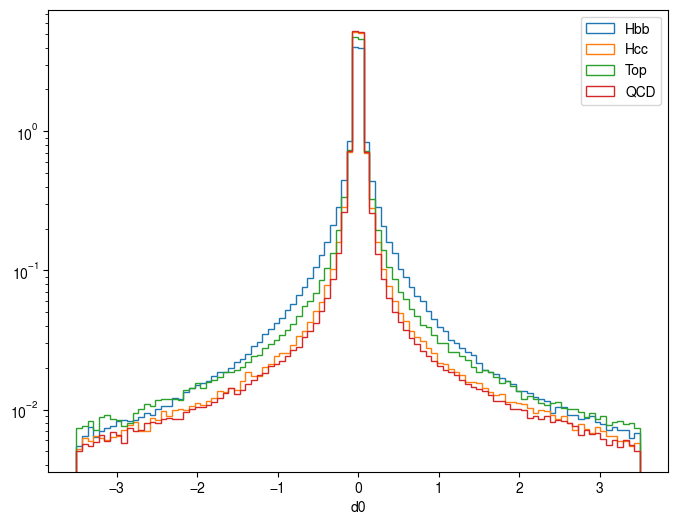

In [45]:
plt.figure(figsize=(8,6))

plt.hist(np.concatenate(tracks['d0'][masks[0]]),
         bins = 100, histtype = 'step', density = True, label = 'Hbb', log = True);

plt.hist(np.concatenate(tracks['d0'][masks[1]]),
         bins = 100, histtype = 'step', density = True, label = 'Hcc', log = True);

plt.hist(np.concatenate(tracks['d0'][masks[2]]),
         bins = 100, histtype = 'step', density = True, label = 'Top', log = True);

plt.hist(np.concatenate(tracks['d0'][masks[3]]),
         bins = 100, histtype = 'step', density = True, label = 'QCD', log = True);

plt.legend();
plt.xlabel('d0');

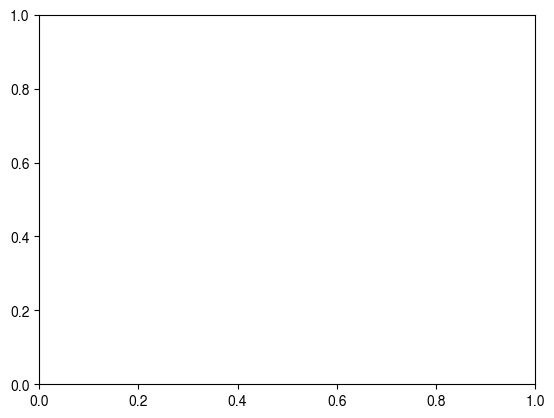

In [23]:
taggers = {"Xbb2020v3": xbb_rejs,
           "GN2Xv00": gn2x_nominal_rejs,
           "GN2XWithMassv00": gn2x_mass_nominal_rejs}

make_plots_wrapper(taggers, "baseline-both3.png")

![](xbb_plots/baseline-both3.png)

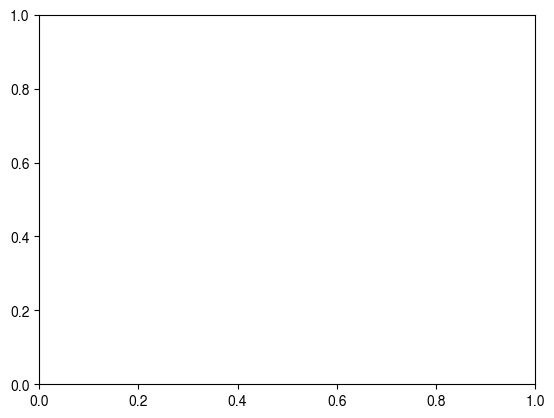

In [24]:
taggers = {"Xbb2020v3": xbb_rejs,
           "GN2Xv00": gn2x_nominal_rejs,}

make_plots_wrapper(taggers, "baseline-gn2xv00-4.png")

![](xbb_plots/baseline-gn2xv00-4.png)

In [27]:
gn2x_disc_25_0 = discriminant(df, "GN2Xv00", ftop = 0.25, fhcc = 0)
gn2x_rejs_25_0 = get_rejections(gn2x_disc_25_0, masks[0], masks[1:])

gn2x_disc_25_01 = discriminant(df, "GN2Xv00", ftop = 0.25, fhcc = 0.01)
gn2x_rejs_25_01 = get_rejections(gn2x_disc_25_01, masks[0], masks[1:])

gn2x_disc_25_02 = discriminant(df, "GN2Xv00", ftop = 0.25, fhcc = 0.02)
gn2x_rejs_25_02 = get_rejections(gn2x_disc_25_02, masks[0], masks[1:])

gn2x_disc_25_03 = discriminant(df, "GN2Xv00", ftop = 0.25, fhcc = 0.03)
gn2x_rejs_25_03 = get_rejections(gn2x_disc_25_03, masks[0], masks[1:])

gn2x_disc_25_04 = discriminant(df, "GN2Xv00", ftop = 0.25, fhcc = 0.04)
gn2x_rejs_25_04 = get_rejections(gn2x_disc_25_04, masks[0], masks[1:])

gn2x_disc_25_05 = discriminant(df, "GN2Xv00", ftop = 0.25, fhcc = 0.05)
gn2x_rejs_25_05 = get_rejections(gn2x_disc_25_05, masks[0], masks[1:])

gn2x_disc_25_1 = discriminant(df, "GN2Xv00", ftop = 0.25, fhcc = 0.1)
gn2x_rejs_25_1 = get_rejections(gn2x_disc_25_1, masks[0], masks[1:])

gn2x_disc_10_02 = discriminant(df, "GN2Xv00", ftop = 0.10, fhcc = 0.02)
gn2x_rejs_10_02 = get_rejections(gn2x_disc_10_02, masks[0], masks[1:])

gn2x_disc_15_02 = discriminant(df, "GN2Xv00", ftop = 0.15, fhcc = 0.02)
gn2x_rejs_15_02 = get_rejections(gn2x_disc_15_02, masks[0], masks[1:])

gn2x_disc_20_02 = discriminant(df, "GN2Xv00", ftop = 0.20, fhcc = 0.02)
gn2x_rejs_20_02 = get_rejections(gn2x_disc_20_02, masks[0], masks[1:])

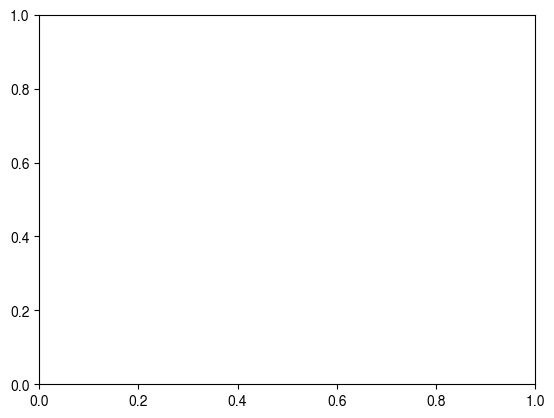

In [28]:
# taggers = {
#     "Xbb2020v3": xbb_rejs,
#     "GN2X: ftop = 0.25, fhcc = 0": gn2x_rejs_25_0,
#     "GN2X: ftop = 0.25, fhcc = 0.01": gn2x_rejs_25_01,
# #     "GN2X: ftop = 0.25, fhcc = 0.02": gn2x_rejs_25_02,
# #     "GN2X: ftop = 0.25, fhcc = 0.05": gn2x_rejs_25_05,
#     "GN2X: ftop = 0.25, fhcc = 0.1": gn2x_rejs_25_1,
# }
# make_plots_wrapper(taggers, "baseline_fhcc_new4.png")

# taggers = {
#     "GN2X: ftop = 0.25, fhcc = 0": gn2x_rejs_25_0,
#     "GN2X: ftop = 0.25, fhcc = 0.01": gn2x_rejs_25_01,
#     "GN2X: ftop = 0.25, fhcc = 0.02": gn2x_rejs_25_02,
#     "GN2X: ftop = 0.25, fhcc = 0.03": gn2x_rejs_25_03,
#     "GN2X: ftop = 0.25, fhcc = 0.04": gn2x_rejs_25_04,
#     "GN2X: ftop = 0.25, fhcc = 0.05": gn2x_rejs_25_05,
# }

# make_plots_wrapper(taggers, "baseline_fhcc_new-precise2.png")


taggers = {
#     "Xbb2020v3": xbb_rejs,
    "GN2X: ftop = 0.25, fcc = 0.02": gn2x_rejs_25_02,
    "GN2X: ftop = 0.20, fcc = 0.02": gn2x_rejs_20_02,
    "GN2X: ftop = 0.15, fcc = 0.02": gn2x_rejs_15_02,
    "GN2X: ftop = 0.10, fcc = 0.02": gn2x_rejs_10_02
}
make_plots_wrapper(taggers, "baseline_ftop_new3.png")

![](xbb_plots/baseline_fhcc_new4.png)

![](xbb_plots/baseline_fhcc_new-precise2.png)

![](xbb_plots/baseline_ftop_new3.png)

## Training With Inclusive Top Sample

In [29]:
with h5py.File("/share/rcifdata/jbarr/salt/salt/logs/GN2X_top_20230526-T145855/ckpts/epoch=039-val_loss=0.41672__test_pp_output_test.h5") as f:
    gn2x_top = pd.DataFrame(f["jets"][:])
    
top_masks = flavour_masks(gn2x_top)
top_disc = discriminant(gn2x_top, "GN2X_top")
top_rejs = get_rejections(top_disc, top_masks[0], top_masks[1:])

gn2x_disc = discriminant(gn2x_top, "GN2Xv00")
gn2x_rejs = get_rejections(gn2x_disc, top_masks[0], top_masks[1:])

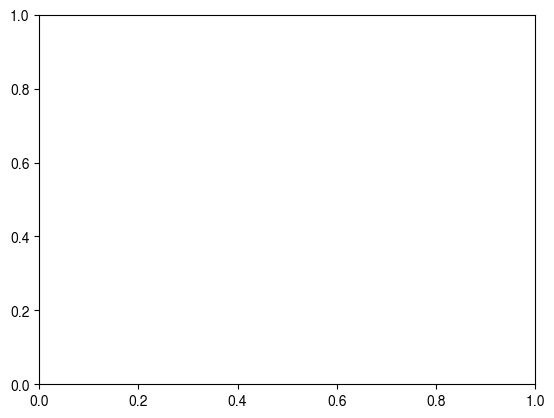

In [30]:
taggers = {"GN2Xv00": gn2x_rejs, 
           "GN2X - Inclusive Top": top_rejs
          }

make_plots_wrapper(taggers, "top_comp_new.png")

![](xbb_plots/top_comp_new.png)

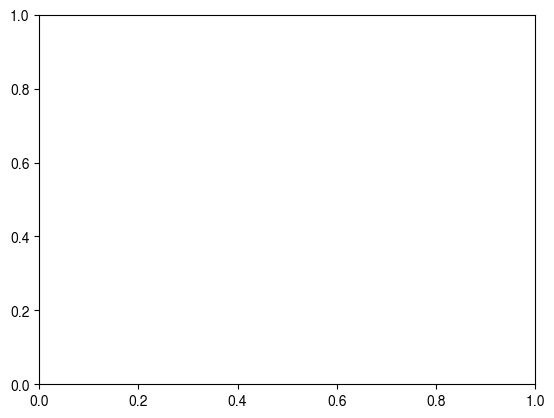

In [32]:
top_rejs_25 = get_rejections(top_disc, top_masks[0], top_masks[1:])
top_disc_15 = discriminant(gn2x_top, "GN2X_top", ftop = 0.15)
top_rejs_15 = get_rejections(top_disc_15, top_masks[0], top_masks[1:])

taggers = {"GN2Xv00 ftop = 0.25": gn2x_rejs,
           "GN2X - Inclusive Top ftop = 0.25": top_rejs_25, 
           "GN2X - Inclusive Top ftop = 0.15": top_rejs_15,
          }

make_plots_wrapper(taggers, "top_comp_ftop_new2.png")

![](xbb_plots/top_comp_ftop_new2.png)

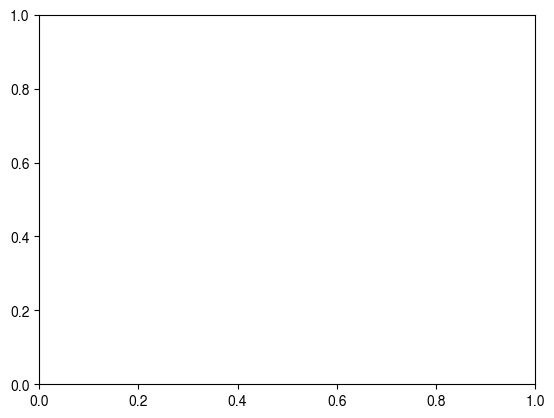

In [34]:
top_masks_ext = flavour_masks(gn2x_top, other_top = True)

top_rejs_ext = get_rejections(top_disc, top_masks_ext[0], top_masks_ext[2:-1])
gn2x_rejs_ext = get_rejections(gn2x_disc, top_masks_ext[0], top_masks_ext[2:-1])



plot_roc = RocPlot(
    n_ratio_panels=3,
    ylabel="Background rejection",
    xlabel="Hbb efficiency",
    figsize=(6.5, 6),
    y_scale=1.4,
)

sig_eff = np.linspace(0.5, 1.0, 40)

tqqb = Flavour("tqqb", "tqqb", cuts = None, colour = None, category = None)
Wqq_from_top = Flavour("Wqq_from_top", "Wqq", cuts = None, colour = None, category = None)
other_from_top = Flavour("other_from_top", "other", cuts = None, colour = None, category = None)

plot_roc.leg_rej_labels = {"hcc": "tqqb", "top": "Wqq_from_top", "qcd": "other_from_top"}


taggers = {"GN2Xv00": gn2x_rejs_ext, "GN2X - Inclusive Top": top_rejs_ext}


for idx, rej_class in enumerate([tqqb,Wqq_from_top,other_from_top]):#enumerate(["tqqb", "Wqq_from_top", "other_from_top"]):
    ratio_bool = True
    for label, rejs in taggers.items():
        plot_roc.add_roc(
            Roc(
                sig_eff,
                rejs[idx],
                n_test=1e6,
                rej_class=rej_class,
                signal_class="hbb",
                label=label,
            ),
            reference=ratio_bool,
        )
        ratio_bool = False

        
plot_roc.set_ratio_class(1, tqqb)
plot_roc.set_ratio_class(2, Wqq_from_top)
plot_roc.set_ratio_class(3, other_from_top)
plot_roc.draw();
plot_roc.savefig("xbb_plots/top_comp_ext2.png", transparent=False)

![](xbb_plots/top_comp_ext2.png)

## Tracks + Subjets Training

In [35]:
with h5py.File("/share/rcifdata/jbarr/salt/salt/logs/GN2X_subjets_20230528-T095731/ckpts/epoch=038-val_loss=0.38567__test_pp_output_test.h5") as f:
    gn2x_subjets = pd.DataFrame(f["jets"][:])

In [45]:
subjets_masks = flavour_masks(gn2x_subjets)
subjets_disc = discriminant(gn2x_subjets, "GN2X_subjets")
subjets_rej = get_rejections(subjets_disc, subjets_masks[0], subjets_masks[1:])

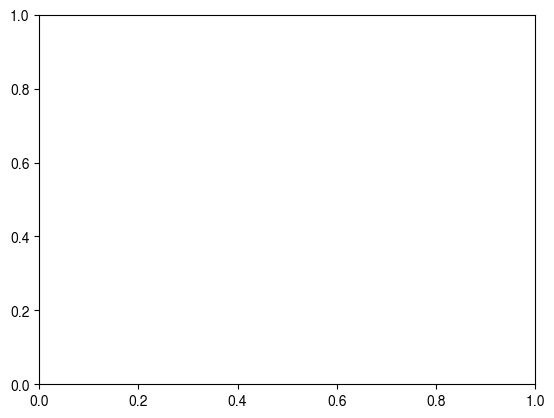

In [46]:
taggers = {"GN2Xv00": gn2x_rejs,
           "GN2X - Inclusive Top": top_rejs, 
           "GN2X - Tracks + Subjets": subjets_rej,
          }

make_plots_wrapper(taggers, "subjets5.png")

![](xbb_plots/subjets5.png)

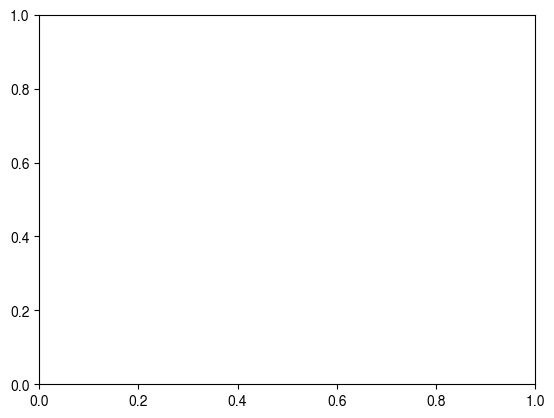

In [47]:
taggers = {
           "Xbb2020v3": xbb_rejs,
           "GN2Xv00": gn2x_rejs,
           "GN2X - Tracks + Subjets": subjets_rej,
          }

make_plots_wrapper(taggers, "subjets_xbb.png")

![](xbb_plots/subjets_xbb.png)

GN2X - Inclusive Top ['/share/rcifdata/jbarr/salt/salt/logs/GN2X_top_20230526-T145855/ckpts/epoch=039-val_loss=0.41672__test_pp_output_test.h5', 'GN2X_top', False]
GN2X - Tracks + Subjets ['/share/rcifdata/jbarr/salt/salt/logs/GN2X_subjets_20230528-T095731/ckpts/epoch=038-val_loss=0.38567__test_pp_output_test.h5', 'GN2X_subjets', False]
GN2Xv00 ['/share/lustre/jbarr/training-files/top/output/pp_output_test.h5', 'GN2Xv00', True]


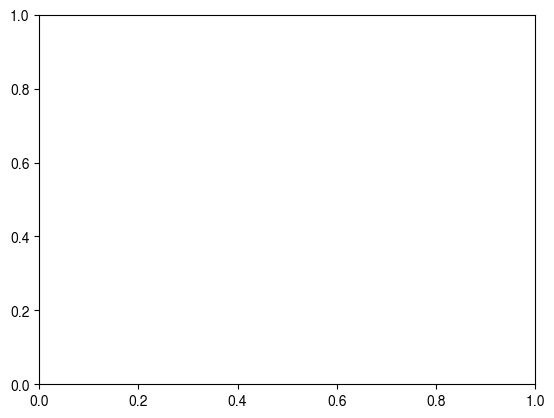

In [66]:
taggers = {
    "GN2X - Inclusive Top" : ["/share/rcifdata/jbarr/salt/salt/logs/GN2X_top_20230526-T145855/ckpts/epoch=039-val_loss=0.41672__test_pp_output_test.h5",
                             "GN2X_top", False],
    "GN2X - Tracks + Subjets": [f"/share/rcifdata/jbarr/salt/salt/logs/GN2X_subjets_20230528-T095731/ckpts/epoch=038-val_loss=0.38567__test_pp_output_test.h5",
                               "GN2X_subjets", False]
}


test_path = f"/share/lustre/jbarr/training-files/top/output/pp_output_test.h5"
save_dir = f"xbb_plots"

pt_min = 250e3
pt_max = 5000e3
mass_min = 50e3

num_jets = 5e6

cuts = [
    ("pt", ">", pt_min),
    ("pt", "<", pt_max),
    #("mass", ">", mass_min),
]

#make_plots("hbb", taggers, cuts, test_path, save_dir)
make_plots("hbb", taggers, cuts, test_path, save_dir, ext = "_gn2xv00_comp.png", baseline=True)

In [120]:
subjets_masks = flavour_masks(gn2x_subjets)
subjets_disc = discriminant(gn2x_subjets, "GN2X_subjets")

In [123]:
plt.figure(figsize=(10,8))

plt.hist(gn2x_subjets["GN2X_subjets_phbb"][subjets_masks[0]], bins = 100, log = True, histtype = "step", density = True);
plt.hist(gn2x_subjets["GN2X_subjets_phcc"][subjets_masks[1]], bins = 100, log = True, histtype = "step", density = True);
plt.hist(gn2x_subjets["GN2X_subjets_ptop"][subjets_masks[2]], bins = 100, log = True, histtype = "step", density = True);
plt.hist(gn2x_subjets["GN2X_subjets_pqcd"][subjets_masks[3]], bins = 100, log = True, histtype = "step", density = True);